In [1]:
import numpy as np
import seaborn as sns
import torch
import wandb
from contextual_gaussian import ContextDataset, ContextualGMM, ContextualGaussian
from dvi_process import DIS
from matplotlib import pyplot as plt
from score_function import ScoreFunction
from torch.distributions import Normal
from torch.utils.data import DataLoader
from train import train

In [2]:
import torch_directml
device = torch.device("cpu") # = torch_directml.device()

In [3]:
dataset = ContextDataset(size=4096)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)

In [4]:
c_dim = 1
z_dim = 1
h_dim = 32
num_layers = 3
num_steps = 16
learning_rate = 3e-4
non_linearity = "SiLU"

In [5]:
score_function = ScoreFunction(c_dim=c_dim, h_dim=h_dim, z_dim=z_dim, num_layers=num_layers, non_linearity=non_linearity, num_steps=num_steps)
dvi_process = DIS(device=device, z_dim=z_dim, num_steps=num_steps, score_function=score_function).to(device)

optimizer = torch.optim.Adam(dvi_process.parameters(), lr=learning_rate)

In [6]:
wandb_logging = True
if wandb_logging:
    wandb.init(project="dvi")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [11]:
losses = train(dvi_process, device, dataloader, optimizer, 4000, wandb_logging=wandb_logging)

  0%|          | 0/1 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'contextual_gaussian.ContextualGMM'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'contextual_gaussian.ContextualGMM'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


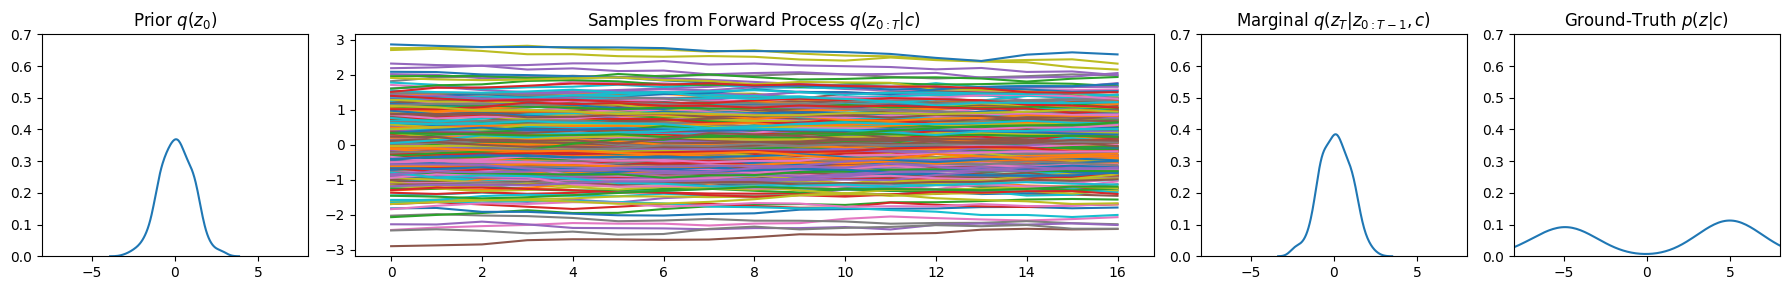

In [15]:
num_samples = 256

context = torch.zeros((z_dim), device=device).unsqueeze(0).repeat(num_samples, 1) 
# context = torch.ones((z_dim), device=device).unsqueeze(0).repeat(num_samples, 1) * 5

p_z_0 = Normal(
    torch.zeros((num_samples, z_dim), device=device),
    torch.ones((num_samples, z_dim), device=device) # * dvi_process.sigmas[0],
)

p_z_T = ContextualGMM(context)

dvi_process.eval()
with torch.no_grad():
    _, z_samples = dvi_process.run_chain(p_z_0, p_z_T, context.to(device))

    z_0_samples = z_samples[0].squeeze(1).tolist()
    z_T_samples = z_samples[-1].squeeze(1).tolist()

    z_trajectories = [[z[i].cpu().numpy() for z in z_samples] for i in range(num_samples)]

    z_samples = p_z_T.sample().squeeze(1).tolist()

fig, ax = plt.subplots(1, 4, figsize=(18, 3), gridspec_kw={'width_ratios': [1, 3, 1, 1]})

sns.kdeplot(z_0_samples, ax=ax[0])
ax[0].set_title("Prior $q(z_0)$")
ax[0].set_ylabel(None)
ax[0].set_xlim(-8, 8)
ax[0].set_ylim(0, 0.7)

for i in range(num_samples):
    ax[1].plot(z_trajectories[i])
ax[1].set_title("Samples from Forward Process $q(z_{0:T}|c)$")

sns.kdeplot(z_T_samples, ax=ax[2])
ax[2].set_title("Marginal $q(z_T|z_{0:T-1},c)$")
ax[2].set_ylabel(None)
ax[2].set_xlim(-8, 8)
ax[2].set_ylim(0, 0.7)

sns.kdeplot(z_samples, ax=ax[3])
ax[3].set_title("Ground-Truth $p(z|c)$")
ax[3].set_ylabel(None)
ax[3].set_xlim(-8, 8)
ax[3].set_ylim(0, 0.7)

plt.tight_layout()
plt.show()